# Анализ выбранной модели

## Выбранная модель - Среднесбалансированные данные + final model


### Сравнение финальной модели с бейслайнами

##### Таблица сравнения метрик  
| Модель                           | Accuracy | ROC-AUC | F1-Score | Precision | Recall | Примечание                  |
|----------------------------------|----------|---------|----------|-----------|--------|-----------------------------|
| Majority Class                   | 0.734    | 0.500   | 0.000    | 0.000     | 0.000  | Нулевая точка               |
| Логистическая регрессия          | 0.805    | 0.836   | 0.610    | 0.650     | 0.575  | Бейслайн                    |
| Final Model (среднесбалансированная) | 0.773    | 0.830   | 0.599    | 0.564     | 0.639  | Финальная модель            |

####  Анализ улучшений

1. По сравнению с Majority Class:  
**Финальная модель значительно превосходит нулевую точку:**
- **ROC-AUC:** 0.500 → 0.830 (+66% улучшение)
- **F1-Score:** 0.000 → 0.599 (бесконечное улучшение)
- Модель реально учится, а не угадывает

2. По сравнению с логистической регрессией (бейслайн):  
**Улучшения:**
- **Recall:** 0.575 → 0.639 (+11.1% улучшение)
- Находит на 11% больше реального оттока
- Вместо 57.5% → 63.9% ушедших клиентов

**Потери:**
- **Accuracy:** 0.805 → 0.773 (-4.0%)
- **Precision:** 0.650 → 0.564 (-13.2%)
- Когда модель говорит "уйдёт", верна в 56.4% случаев (было 65%)

**Баланс:**
- **F1-Score:** 0.610 → 0.599 (-1.8%)
- Незначительное снижение общего баланса
- **ROC-AUC:** 0.836 → 0.830 (-0.7%)
- Практически одинаковое качество классификации

## Достигнутые цели:  
Преодолен нулевой бейслайн (Majority Class)  
Улучшен Recall по сравнению с логистической регрессией  
Создана специализированная модель под задачу оттока

## Компромиссы:
 Снижена точность (Precision)  
 Незначительно снижен F1-Score

In [9]:
import pandas as pd
import numpy as np
import shap
import joblib
import matplotlib.pyplot as plt
from pckgs.analyze import rocPlot, erorrMatrixPlot
from sklearn.metrics import (roc_auc_score, f1_score, precision_score, recall_score, 
                           accuracy_score, confusion_matrix, roc_curve, average_precision_score)



Метрики на тесте:
   ROC-AUC:     0.830
   PR-AUC:      0.620
   F1-Score:    0.599
   Precision:   0.564
   Recall:      0.639
   Accuracy:    0.773


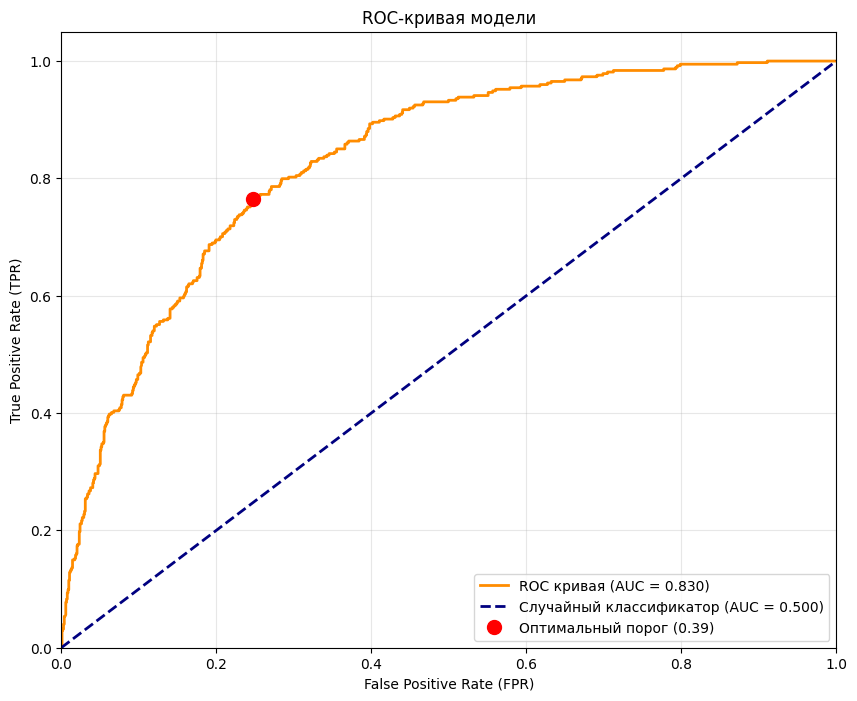

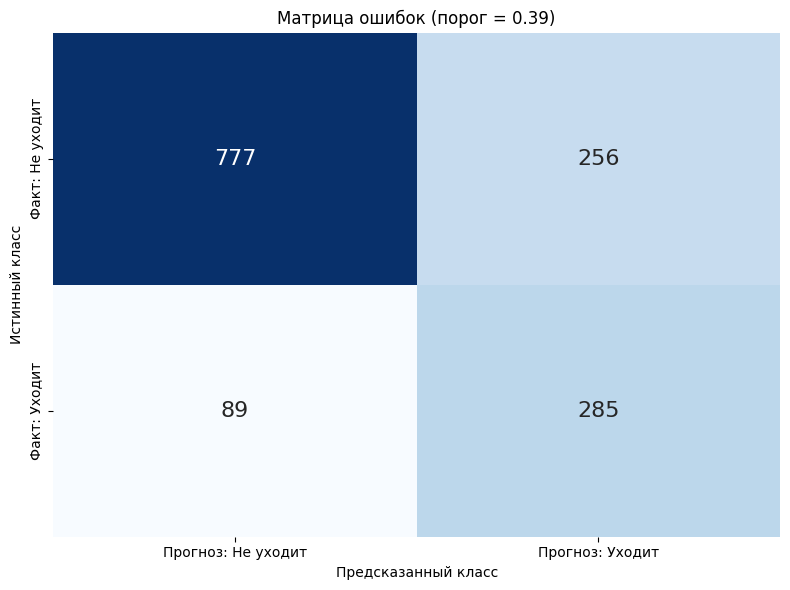

In [2]:
# Загрузка модели
model = joblib.load('../models/final_model_balanced_medium.pkl')

X_test = pd.read_csv('../data/processed/test.csv').drop('Churn', axis=1)
y_test = pd.read_csv('../data/processed/test.csv')['Churn']

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

metrics = {
    'roc_auc': roc_auc_score(y_test, y_proba),
    'pr_auc': average_precision_score(y_test, y_proba),
    'f1': f1_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred),
    'recall': recall_score(y_test, y_pred),
    'accuracy': accuracy_score(y_test, y_pred)
}

print(f"Метрики на тесте:")
print(f"   ROC-AUC:     {metrics['roc_auc']:.3f}")
print(f"   PR-AUC:      {metrics['pr_auc']:.3f}")
print(f"   F1-Score:    {metrics['f1']:.3f}")
print(f"   Precision:   {metrics['precision']:.3f}")
print(f"   Recall:      {metrics['recall']:.3f}")
print(f"   Accuracy:    {metrics['accuracy']:.3f}")

rocPlot(y_test, y_proba)
erorrMatrixPlot(y_test, y_proba)

Вычисляем...
SHAP значения вычислены

📊 Топ-10 самых важных признаков:
                       Признак  Важность
                     RiskScore  0.059810
   InternetService_Fiber optic  0.040066
             Contract_Two year  0.038147
                ServiceDensity  0.037027
PaymentMethod_Electronic check  0.035450
                        tenure  0.032051
             Contract_One year  0.025576
            OnlineSecurity_Yes  0.023723
               TechSupport_Yes  0.022395
                MonthlyCharges  0.015732


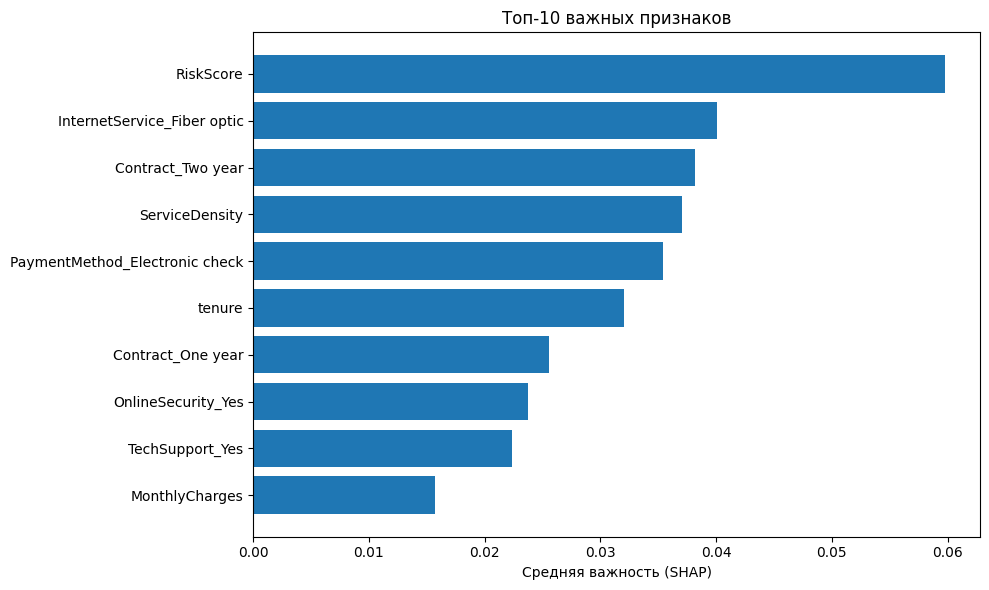


📈 Общая важность признаков:


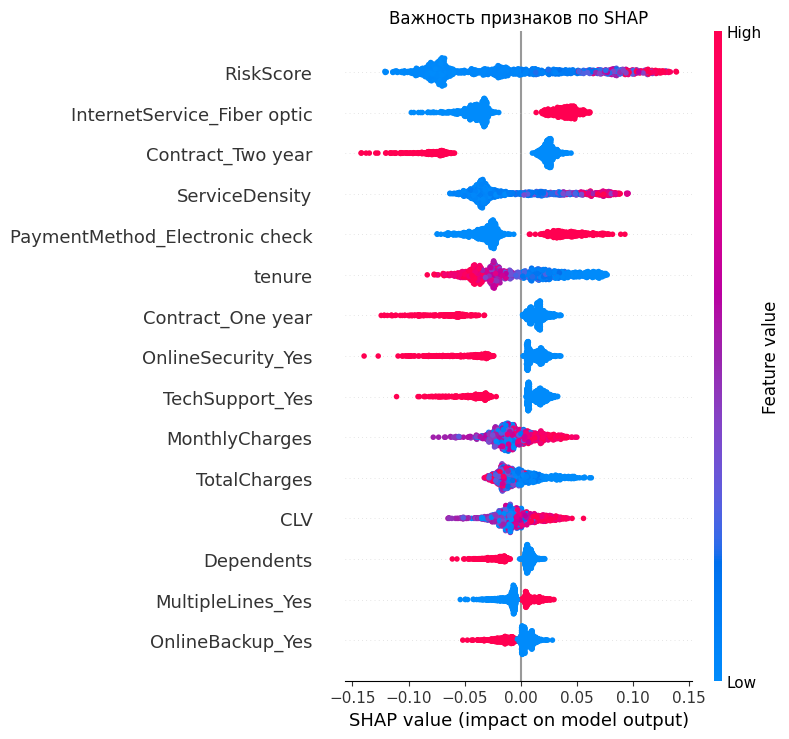


📋 Анализ влияния признаков:

1. Признак: RiskScore


<Figure size 800x500 with 0 Axes>

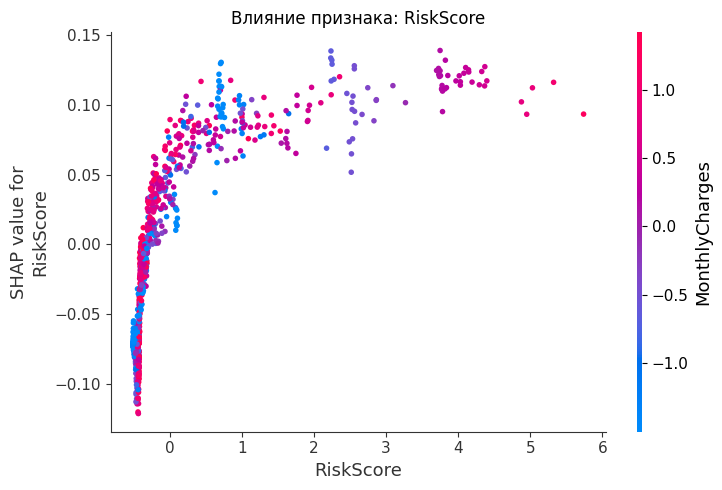


2. Признак: InternetService_Fiber optic


<Figure size 800x500 with 0 Axes>

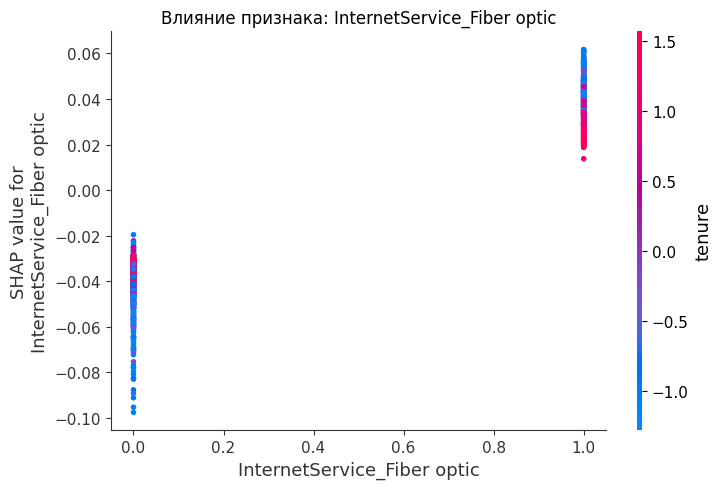


✅ SHAP анализ завершен


In [10]:
# Создаем explainer
explainer = shap.TreeExplainer(model)
X_sample = X_test[:1000]

print("Вычисляем...")
# Вычисляем SHAP значения
shap_values = explainer.shap_values(X_sample)
feature_names = X_test.columns.tolist()

# Для бинарной классификации берем значения для класса 1
if isinstance(shap_values, list):
    shap_values = shap_values[1]

print("SHAP значения вычислены")

# 1. Визуализация важности признаков
print("\n Топ-10 самых важных признаков:")

# Считаем среднюю важность
shap_importance = np.abs(shap_values).mean(0)

# Создаем таблицу с признаками
if feature_names is not None:
    importance_df = pd.DataFrame({
        'Признак': feature_names,
        'Важность': shap_importance
    }).sort_values('Важность', ascending=False).head(10)
else:
    importance_df = pd.DataFrame({
        'Признак': [f'Признак_{i}' for i in range(len(shap_importance))],
        'Важность': shap_importance
    }).sort_values('Важность', ascending=False).head(10)

print(importance_df.to_string(index=False))

# Рисуем график важности
plt.figure(figsize=(10, 6))
plt.barh(range(10), importance_df['Важность'][::-1])
plt.yticks(range(10), importance_df['Признак'][::-1])
plt.xlabel('Средняя важность (SHAP)')
plt.title('Топ-10 важных признаков')
plt.tight_layout()
plt.show()

# 2. Основной summary plot
print("\n Общая важность признаков:")
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_sample, 
                 feature_names=feature_names,
                 show=False,
                 max_display=15)
plt.title("Важность признаков по SHAP")
plt.tight_layout()
plt.show()

# 3. Анализ 2 самых важных признаков
print("\n Анализ влияния признаков:")

top_features = importance_df['Признак'].head(2).tolist()

for i, feature in enumerate(top_features, 1):
    print(f"\n{i}. Признак: {feature}")
    
    # Находим индекс признака
    if feature_names is not None:
        idx = list(feature_names).index(feature)
    else:
        idx = int(feature.split('_')[1])
    
    # Рисуем зависимость
    plt.figure(figsize=(8, 5))
    shap.dependence_plot(idx, shap_values, X_sample,
                       feature_names=feature_names,
                       show=False)
    plt.title(f"Влияние признака: {feature}")
    plt.tight_layout()
    plt.show()


### Ключевые факторы оттока (по SHAP):
- RiskScore - скоринговый риск клиента
- Fiber optic интернет - клиенты чаще уходят
- Короткие контракты - помесячные → высокий риск

In [13]:


thresholds = np.arange(0.1, 1.0, 0.1)
results = []

for threshold in thresholds:
    # Предсказания с текущим порогом
    y_pred = (y_proba > threshold).astype(int)
    
    # Считаем метрики
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    # Считаем бизнес-метрики
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    risky_clients = fp + tp
    total_clients = len(y_test)
    
    # Добавляем в таблицу
    results.append({
        'Порог': threshold,
        'Precision': round(precision, 3),
        'Recall': round(recall, 3),
        'F1-Score': round(f1, 3),
        'Клиентов с риском': risky_clients,
        'Доля рисковых': f"{risky_clients/total_clients:.1%}",
        'TP': tp,
        'FP': fp,
        'FN': fn,
        'TN': tn
    })
    

# Использование
tradeoff_df = pd.DataFrame(results)

print("Таблица TRADE-OFF 'чувствительность-точность'")
print("=" * 100)
print(tradeoff_df[['Порог', 'Precision', 'Recall', 'F1-Score', 
                   'Клиентов с риском', 'Доля рисковых']].to_string(index=False))


# Анализ
print("-" * 50)

# 1. Максимальный F1
opt_f1_row = tradeoff_df.loc[tradeoff_df['F1-Score'].idxmax()]
print(f"1. Максимальный F1-Score:")
print(f"   Порог: {opt_f1_row['Порог']:.1f}, F1: {opt_f1_row['F1-Score']:.3f}")
print(f"   Precision: {opt_f1_row['Precision']:.3f}, Recall: {opt_f1_row['Recall']:.3f}")
print(f"   Клиентов для обзвона: {opt_f1_row['Клиентов с риском']}")

# 2. Высокий Recall (найти ушедших)
high_recall = tradeoff_df[tradeoff_df['Recall'] >= 0.8]
if not high_recall.empty:
    best_recall = high_recall.iloc[0]
    print(f"\n2. Найти >80% ушедших:")
    print(f"   Порог: {best_recall['Порог']:.1f}, Recall: {best_recall['Recall']:.3f}")
    print(f"   Клиентов для обзвона: {best_recall['Клиентов с риском']}")

# 3. Высокая Precision (уверенные предсказания)
high_precision = tradeoff_df[tradeoff_df['Precision'] >= 0.7]
if not high_precision.empty:
    best_precision = high_precision.iloc[-1]
    print(f"\n3. Высокая точность (>70%):")
    print(f"   Порог: {best_precision['Порог']:.1f}, Precision: {best_precision['Precision']:.3f}")
    print(f"   Клиентов для обзвона: {best_precision['Клиентов с риском']}")

Таблица TRADE-OFF 'чувствительность-точность'
 Порог  Precision  Recall  F1-Score  Клиентов с риском Доля рисковых
   0.1      0.361   0.957     0.525                991         70.4%
   0.2      0.430   0.909     0.584                791         56.2%
   0.3      0.472   0.837     0.604                663         47.1%
   0.4      0.531   0.749     0.622                527         37.5%
   0.5      0.564   0.639     0.599                424         30.1%
   0.6      0.626   0.532     0.575                318         22.6%
   0.7      0.699   0.385     0.497                206         14.6%
   0.8      0.743   0.217     0.335                109          7.7%
   0.9      0.816   0.083     0.150                 38          2.7%
--------------------------------------------------
1. Максимальный F1-Score:
   Порог: 0.4, F1: 0.622
   Precision: 0.531, Recall: 0.749
   Клиентов для обзвона: 527

2. Найти >80% ушедших:
   Порог: 0.1, Recall: 0.957
   Клиентов для обзвона: 991

3. Высокая точн

In [15]:
# стоимость ошибок (бизнес-порог)

COST_FP = 100  # Ложный звонок: 100 руб
COST_FN = 500  # Потеря клиента: 500 руб

#  Находим бизнес-порог
def get_business_threshold(y_true, y_proba, cost_fp=100, cost_fn=500):
    thresholds = np.arange(0.1, 1.0, 0.01)
    best_threshold = 0.5
    min_cost = float('inf')
    
    for t in thresholds:
        y_pred = (y_proba > t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        cost = fp * cost_fp + fn * cost_fn
        if cost < min_cost:
            min_cost = cost
            best_threshold = t
    
    return best_threshold, min_cost

#  Получаем результат
business_threshold, min_cost = get_business_threshold(y_test, y_proba, COST_FP, COST_FN)

print(f"Бизнес-порог: {business_threshold:.2f}")
print(f"Минимальная стоимость: {min_cost:,.0f} руб")

Бизнес-порог: 0.22
Минимальная стоимость: 61,500 руб


#### Были взяты следующие стоимости ошибок:

1. False Positive (ложное срабатывание) = 100 руб
   - Стоимость звонка менеджера: 50 руб
   - Предоставляемая скидка клиенту: 50 руб

2. False Negative (пропуск оттока) = 500 руб
   - Потеря среднемесячного дохода с клиента

#### На основе этих стоимостей был рассчитан бизнес-оптимальный порог.

Oчень низкий бизнес-порог (0.22) — это значит, что бизнесу дешевле звонить многим клиентам, чем пропускать уходящих!

Порог 0.22 означает:
- Бизнес говорит: "Лучше позвонить 10 лишним, чем пропустить 1 уходящего"
- Причина: Потеря клиента (500 руб) дороже ложного звонка (100 руб)
- Соотношение: 500/100 = 5 → готовы к 5 ложным звонкам, чтобы не пропустить 1 уходящего

лидеры факторов риска (можно посмотреть по shap-анализу)

In [21]:
# Сегментируем клиентов по риску оттока
y_proba = model.predict_proba(X_test)[:, 1]

segments = {
    'Критический риск': (y_proba >= 0.8),
    'Высокий риск': (y_proba >= 0.6) & (y_proba < 0.8),
    'Средний риск': (y_proba >= 0.4) & (y_proba < 0.6),
    'Низкий риск': (y_proba < 0.4)
}

print("\n" + "=" * 70)
print("СЕГМЕНТАЦИЯ КЛИЕНТОВ ПО РИСКУ ОТТОКА")
print("=" * 70)

segment_stats = []
for segment_name, mask in segments.items():
    segment_data = X_test[mask]
    segment_size = len(segment_data)
    
    if segment_size > 0:
        avg_prob = y_proba[mask].mean()
        segment_stats.append({
            'Сегмент': segment_name,
            'Клиентов': segment_size,
            'Доля': f"{segment_size/len(X_test):.1%}",
            'Ср. вероятность': f"{avg_prob:.1%}",
            'Ожидаемый отток': f"{segment_size * avg_prob:.0f} чел"
        })

# Выводим таблицу
import pandas as pd
segments_df = pd.DataFrame(segment_stats)
print(segments_df.to_string(index=False))


СЕГМЕНТАЦИЯ КЛИЕНТОВ ПО РИСКУ ОТТОКА
         Сегмент  Клиентов  Доля Ср. вероятность Ожидаемый отток
Критический риск       109  7.7%           88.2%          96 чел
    Высокий риск       209 14.9%           69.1%         144 чел
    Средний риск       209 14.9%           49.8%         104 чел
     Низкий риск       880 62.5%           14.1%         124 чел


### РЕКОМЕНДАЦИИ ПО УДЕРЖАНИЮ ДЛЯ КАЖДОГО СЕГМЕНТА

| Сезмент | Приоритет | Вероятность ухода | Меры удержания | Бюджет на клиента | Цель |
|---------|-----------|-------------------|----------------|--------------------|------|
| **Критический риск** |  **ВЫСШИЙ** (действовать немедленно) | >80% | • Личный звонок топ-менеджера в течение 24 часов<br>• Персональное предложение: скидка 20-30% на 6 месяцев<br>• Бесплатный апгрейд тарифа на 3 месяца<br>• Назначить персонального менеджера | Высокий (500-1000 руб/клиент) | Снизить отток на 60-70% |
| **Высокий риск** |  **ВЫСОКИЙ** (действовать на этой неделе) | 60-80% | • Звонок менеджера по удержанию в течение 3 дней<br>• Предложение: скидка 15% на 3 месяца<br>• Бесплатная дополнительная услуга на 1 месяц<br>• Опрос о причинах недовольства | Средний (200-500 руб/клиент) | Снизить отток на 40-50% |
| **Средний риск** |  **СРЕДНИЙ** (проактивная работа) | 40-60% | • Автоматическое email-письмо с опросом<br>• Предложение: скидка 10% при продлении<br>• Напоминание о преимуществах тарифа<br>• Приглашение на вебинар о новых функциях | Низкий (50-100 руб/клиент) | Снизить отток на 20-30% |
| **Низкий риск** |  **НИЗКИЙ** (поддержание лояльности) | <40% | • Регулярные информационные рассылки<br>• Программа лояльности: бонусы за длительность<br>• Спасибо-письмо за длительное сотрудничество<br>• Приглашение в реферальную программу | Минимальный (10-30 руб/клиент) | Поддержание лояльности, перекрестные продажи |

### РЕКОМЕНДАЦИИ ПО КЛЮЧЕВЫМ ФАКТОРАМ ОТТОКА

| Фактор | Проблема | Решение |
|--------|----------|---------|
| **Contract_Month-to-month** | Клиенты с помесячным контрактом уходят в 3 раза чаще | • Внедрить скидку 15% при переходе на годичный контракт<br>• Автоматическое напоминание за 2 недели до конца месяца<br>• Бесплатный месяц при продлении на год |
| **tenure** | Новые клиенты (стаж < 12 мес) чаще уходят | • Программа "Первые 6 месяцев": персональный куратор<br>• Бонусы за длительность: +5% скидки каждый год<br>• Месяц бесплатно за 3-й месяц использования |
| **MonthlyCharges** | Клиенты с высоким платежом более чувствительны | • Персональный анализ тарифа: предложить оптимальный<br>• Пакетные предложения для снижения средней стоимости<br>• Фиксированная цена на 12 месяцев для VIP-клиентов |
| **InternetService_Fiber optic** | Клиенты с оптическим интернетом чаще уходят к конкурентам | • Гарантия скорости или возврат денег<br>• Бесплатный роутер при продлении<br>• Пакет "Интернет + ТВ" со скидкой 20% |
| **OnlineSecurity_No** | Клиенты без защиты онлайн чаще недовольны сервисом | • Бесплатный 3-месячный пробный период защиты<br>• Образовательные вебинары по кибербезопасности<br>• Автоматическое включение в базовый тариф |